# Seame eesmärgi ja tulemusmõõdiku
Iga tehisintellekti esimene samm peaks olema eesmärgi seadmine.

Meie eesmärgiks on luua **mudel, mis prognoosib ettevõtte müügitulu töötajate arvu ja tegevusala põhjal**.

Tulemusmõõdikuna kasutame keskmist absoluutviga ehk mitu eurot meie mudel keskmiselt prognoosi tegemisel eksib. 

# Impordime tööriistad
Prognoosimiseks kasutame Scikit learn teeki, mis sisaldab suurt hulka erinevaid masinõppe algoritme ja tööriistu andmete haldamiseks.
https://scikit-learn.org/stable/ 

In [ ]:
# Impordime vajalikud teegid
import pandas as pd
import sklearn as sk

# Andmete importimine
Impordime allolevas näites .csv faili Avaandmete portaalist saadud andmetega ettevõtete müügitulu ja tasutud maksude kohta. Andmed on eelnevalt salvestatud Github'i.

In [3]:
raw_data_url = 'https://raw.githubusercontent.com/kristjan-eljand/andmeteadus_on_popp/main/maksud_2021_iii_kvartal.csv'
raw_data = pd.read_csv(raw_data_url)
raw_data

reg_code  ... employees
0       10000018  ...     191.0
1       10000024  ...      12.0
2       10000062  ...       NaN
3       10000127  ...       2.0
4       10000165  ...      39.0
...          ...  ...       ...
147252  BB000770  ...       NaN
147253  KK106568  ...       NaN
147254  MM000001  ...       1.0
147255  MM000047  ...       1.0
147256  QQ000003  ...       3.0

[147257 rows x 10 columns]

# Andmete eeltöötlus
## Valime vajalikud muutujad
Antud näites on meil vaja alles jätta kolm muutujat: tegevusala, müügitulu ja töötajate arv.

In [4]:
selected_data = raw_data[['emtak', 'employees', 'revenue']]
selected_data

emtak  ...     revenue
0       HULGI- JA JAEKAUBANDUS; MOOTORSÕIDUKITE JA MOO...  ...  21587224.0
1                                            INFO JA SIDE  ...    144389.0
2                PÕLLUMAJANDUS, METSAMAJANDUS JA KALAPÜÜK  ...     27514.0
3       HULGI- JA JAEKAUBANDUS; MOOTORSÕIDUKITE JA MOO...  ...    158317.0
4       HULGI- JA JAEKAUBANDUS; MOOTORSÕIDUKITE JA MOO...  ...   1582858.0
...                                                   ...  ...         ...
147252  HULGI- JA JAEKAUBANDUS; MOOTORSÕIDUKITE JA MOO...  ...   1230805.0
147253                                    TÖÖTLEV TÖÖSTUS  ...   1251075.0
147254                                                NaN  ...         NaN
147255                                                NaN  ...         NaN
147256  HULGI- JA JAEKAUBANDUS; MOOTORSÕIDUKITE JA MOO...  ...     64996.0

[147257 rows x 3 columns]

## Jätame lihtsuse huvides alles vaid kolm tegevusala "INFO JA SIDE", "TÖÖTLEV TÖÖSTUS" ja "EHITUS"

In [5]:
emtak_to_keep = ['INFO JA SIDE', 'TÖÖTLEV TÖÖSTUS', 'EHITUS']
rows_to_keep = selected_data.emtak.isin(emtak_to_keep)
filtered_data = selected_data.loc[rows_to_keep,:]
filtered_data

emtak  employees    revenue
1          INFO JA SIDE       12.0   144389.0
5       TÖÖTLEV TÖÖSTUS        9.0    33043.0
8       TÖÖTLEV TÖÖSTUS      128.0  5924007.0
9       TÖÖTLEV TÖÖSTUS        6.0    25659.0
10               EHITUS        8.0   141853.0
...                 ...        ...        ...
147242  TÖÖTLEV TÖÖSTUS        NaN    31950.0
147244  TÖÖTLEV TÖÖSTUS        NaN    66935.0
147246     INFO JA SIDE        2.0    28218.0
147250  TÖÖTLEV TÖÖSTUS        NaN        0.0
147253  TÖÖTLEV TÖÖSTUS        NaN  1251075.0

[35735 rows x 3 columns]

## Eemaldame puuduvad andmed
Juba ülalolevast tabelist näeme, et meie andmestikus on puuduvaid väärtusi (NaN) väärtusi.
Eemaldame need read andmestikust (NB: kui andmeid on vähe, peaks eemaldamise asemel need väärtused millegagi asendama - meil hetkel seda probleemi pole).

In [6]:
clean_data = filtered_data.dropna()
clean_data

emtak  employees    revenue
1          INFO JA SIDE       12.0   144389.0
5       TÖÖTLEV TÖÖSTUS        9.0    33043.0
8       TÖÖTLEV TÖÖSTUS      128.0  5924007.0
9       TÖÖTLEV TÖÖSTUS        6.0    25659.0
10               EHITUS        8.0   141853.0
...                 ...        ...        ...
147076     INFO JA SIDE        3.0   143609.0
147079     INFO JA SIDE        6.0    22225.0
147121     INFO JA SIDE        2.0        0.0
147220  TÖÖTLEV TÖÖSTUS        3.0     4059.0
147246     INFO JA SIDE        2.0    28218.0

[17450 rows x 3 columns]

## Vaatame andmed üle

### Uurime andmete üldist jaotust

In [7]:
clean_data.describe(include='all')

emtak     employees       revenue
count    17450  17450.000000  1.745000e+04
unique       3           NaN           NaN
top     EHITUS           NaN           NaN
freq      9012           NaN           NaN
mean       NaN     10.262521  4.121827e+05
std        NaN     40.649160  2.764708e+06
min        NaN      1.000000 -1.331100e+04
25%        NaN      1.000000  1.120875e+04
50%        NaN      3.000000  3.466550e+04
75%        NaN      7.000000  1.281268e+05
max        NaN   1809.000000  2.020712e+08

### Vaatame jaotust tegevusalade järgi

In [8]:
clean_data.emtak.value_counts()

EHITUS             9012
TÖÖTLEV TÖÖSTUS    5566
INFO JA SIDE       2872
Name: emtak, dtype: int64

### Vaatame töötajate arvu ja müügitulu korrelatsiooni

In [9]:
clean_data.corr()

employees   revenue
employees   1.000000  0.793414
revenue     0.793414  1.000000

# Andmete ettevalmistamine masinõppeks

## Muudame kõik muutujad numbrilisteks
Sageli soovime mudelites kasutada muutujaid, mis ei ole numbrilised (N: tegevusala). Masinõppemudelid seevastu tahavad, et kõik muutujad oleksid numbrilised.

Lahendus on luua andmestikku uued binaarsed (0 või 1) muutujad -> üks muutuja iga mittenumbrilise muutuja väärtuse kohta (vt. alljärgnev näide, et paremini mõista).

Lahendada saab seda mitmel eri viisil, kuid kuna meie kasutame oma näites Pandas andmetabelit, siis saame need 0/1 muutujad luua üherealise käsuga `pd.get_dummies`.

In [10]:
# Muudame tekstilise veeru 'emtak' numbrilisteks veergudeks.
numeric_data = pd.get_dummies(data=clean_data, columns=['emtak'])
numeric_data

employees    revenue  ...  emtak_INFO JA SIDE  emtak_TÖÖTLEV TÖÖSTUS
1            12.0   144389.0  ...                   1                      0
5             9.0    33043.0  ...                   0                      1
8           128.0  5924007.0  ...                   0                      1
9             6.0    25659.0  ...                   0                      1
10            8.0   141853.0  ...                   0                      0
...           ...        ...  ...                 ...                    ...
147076        3.0   143609.0  ...                   1                      0
147079        6.0    22225.0  ...                   1                      0
147121        2.0        0.0  ...                   1                      0
147220        3.0     4059.0  ...                   0                      1
147246        2.0    28218.0  ...                   1                      0

[17450 rows x 5 columns]

### Vaatame uuesti korrelatsiooni andmete vahel

In [11]:
# Leiame korrelatsiooni ja ümardame tulemuse kahe komakohani
correlation_matrix = numeric_data.corr().round(2)
correlation_matrix

employees  ...  emtak_TÖÖTLEV TÖÖSTUS
employees                   1.00  ...                   0.14
revenue                     0.79  ...                   0.11
emtak_EHITUS               -0.13  ...                  -0.71
emtak_INFO JA SIDE         -0.01  ...                  -0.30
emtak_TÖÖTLEV TÖÖSTUS       0.14  ...                   1.00

[5 rows x 5 columns]

### Visualiseerime korrelatsioonimaatriksi

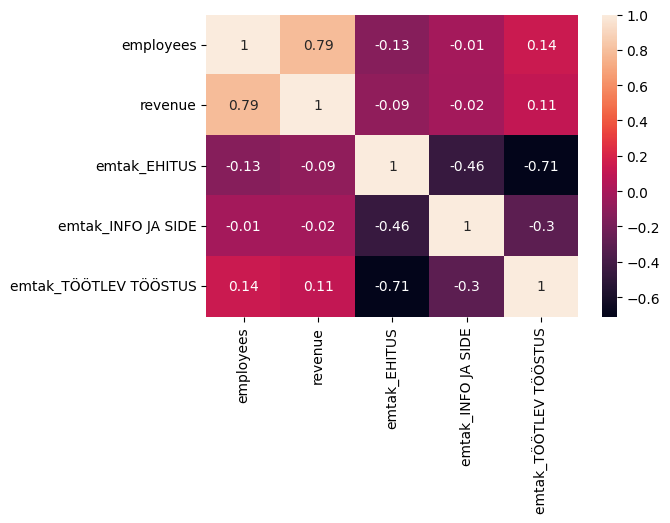

In [12]:
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(dpi=100)
sn.heatmap(correlation_matrix, annot=True)
plt.show()

## Jaotame andmed treening- ja testandmeteks
Treening- ja testandmeid on võimalik moodustada väga erinval moel. Sisuliselt tahame me jaotada oma andmestiku kaheks: 80% jätame treenimiseks ja 20% jätame testimiseks.

Allolevas näites kasutame selle tegemiseks sklearn teegi funktsiooni `train_test_split`, mis loob meile 4 andmestiku ühe käiguga.

In [13]:
from sklearn.model_selection import train_test_split

# Teeme koopia oma andmestikust
ml_data = numeric_data.copy()

# eemaldame müügitulu 'var' ehk prognoositava muutuja prognoosis kasutavatest muutujatest 'vars'
result = ml_data.pop('revenue')
variables = ml_data

# Loome treening ja testandmestikud
train_variables, test_variables, train_result, test_result = train_test_split(variables, result, test_size=0.2, random_state=123)

## Standardiseerime andmed
Hetkel on meie andmestikus nii, et andmete "skaalad" on erinevad. Paljud masinõppealgoritmid tahavad aga, et skaalad oleksid sarnased (N: et kõik muutujad oleks 0 ja 1 vahel).

In [14]:
from sklearn.preprocessing import MinMaxScaler
# Loome ka skaleeritud muutujad
train_variables_minmax = MinMaxScaler().fit_transform(train_variables)
test_variables_minmax = MinMaxScaler().fit_transform(test_variables)

# Prognoosimine

## Prognoosimine lineaarse mudeliga
Lineaarne regressioonmudel on kõige lihtsam võimalik mudel ja annab meile lõpptulemuse kujul y = nx + my + ..., kus y on väärtus, mida ennustame (antud juhul müügitulu), x, y on muutujad (meie mudeli töötajate arv ja tegevusala) ning m,n on muutujate parameetrid.

sklearn teegi hea omadus on, et valikus on küll palju erinevaid mudeleid, kuid nende treenimine käib alati *peaaegu* samamoodi:    
1. impordime mudeli,
2. kasutame `fit(train_variables, train_result)` meetodit treenimiseks,
3. kasutame `predict(test_variables)` meetodit prognoosimiseks.

In [15]:
# Impordime lineaarse regressiooni mudeli
from sklearn.linear_model import LinearRegression

# Treenime mudeli, kasutades treenimise ettenähtud andmeid
model = LinearRegression()
model.fit(X=train_variables, y=train_result)

# Teeme prognoosi testandmete peal
linear_prediction = model.predict(X=test_variables)
linear_prediction

array([  -25931.88302618, 15150399.35135626,  -101267.14605191, ...,
         411571.11630774,    73302.92730663,   266599.03530726])

### Meie mudel on lihtsalt üks matemaatiline valem
Kasutame mudeli meetodit `coef_` et printida välja muutujate parameetrite väärtused.

In [16]:
# Muutujate parameetrid
print("Muutujate parameetrid:", [int(x) for x in model.coef_])

# Vabaliige, mis ütleb, milline on müügitulu eeldatav väärtus, 
# kui muutujate väärtused on nullid
print("Vabaliige:", int(model.intercept_))

Muutujate parameetrid: [48324, 24249, -51085, 26836]
Vabaliige: -98505


### Lisame prognoositud väärtused tegelikele väärtustele

In [17]:
def make_evaluation_table(predictions):
    # Paneme ennustused Pandas formaati
    prediction_series = pd.Series(data=predictions, index=test_result.index, name="prediction")

    # Lisame prognoosiveeru
    evaluate_results = pd.concat([test_variables, test_result, prediction_series], axis=1)

    # Lisame nimeveeru algsest andmestikust
    evaluate_results = pd.merge(raw_data['name'], evaluate_results, left_index=True, right_index=True)
    return evaluate_results

linear_eval_table = make_evaluation_table(linear_prediction)
linear_eval_table

name  ...    prediction
36                                     ESTIKO-PLASTAR, AS  ...  7.998443e+06
45                                          CE TEHNIKA OÜ  ...  2.497890e+04
86                                           SAVEKATE, OÜ  ...  2.341945e+06
91                                            SKILINE, OÜ  ... -2.593188e+04
102                                         ANNINET-V, OÜ  ...  2.665990e+05
...                                                   ...  ...           ...
144394                    MITTETULUNDUSÜHING HIIUMAA KINO  ... -1.012671e+05
145438  MTÜ NORDIC INSTITUTE FOR INTEROPERABILITY SOLU...  ...  4.370493e+04
146740                              IURIDICUM, SIHTASUTUS  ...  1.403530e+05
146826                           KULTUURILEHT, SIHTASUTUS  ...  4.876108e+06
147079                                EMAKEELE SIHTASUTUS  ...  1.403530e+05

[3490 rows x 7 columns]

### Visualiseerime prognoosi ja tegelikud andmed graafikul

In [18]:
!pip install -q plotly
import plotly.express as px

In [19]:
def plot_pred_and_actual(evaluation_table, model_name):
    plot_data = evaluation_table.sort_values(by="revenue", ascending=False).iloc[1:120,]
    plot_data = plot_data[['name','revenue', 'prediction']]
    plot_data = plot_data.melt(id_vars='name', value_vars=['revenue', 'prediction'], var_name='type')


    fig = px.line(plot_data, 
                y='value',
                color='type',
                title=f"Prognoositud vs Tegelik müügitulu ({model_name})")
    fig.show()

plot_pred_and_actual(linear_eval_table, "Lineaarne mudel")

### Tulemuste statistiline hindamine
Tulemuste statistiliseks hindamiseks kasutame kaht mõõdikut: 
* keskmine absoluutviga
* R2 skoor, mis näitab, kui suure osa ennustatavast muutujast suudab meie prognoos ära kirjeldada.

In [20]:
from sklearn.metrics import mean_absolute_error, r2_score

def result_stats_printer(test_result, prediction):
    # Arvutame keskmise absoluutvea
    mae = mean_absolute_error(test_result, prediction)
    print(f"Mudeli keskmine absoluutviga on {mae:.0f} €")

    # Arvutame R2 statistiku
    r2 = r2_score(test_result, prediction)
    print(f"Meie muutujad suudavad kirjeldada {r2*100:.0f}% müügitulu muutusest.")

result_stats_printer(test_result, linear_prediction)

Mudeli keskmine absoluutviga on 359035 €
Meie muutujad suudavad kirjeldada 62% müügitulu muutusest.


## Proovime ka otsustuspuu mudelit

In [21]:
from sklearn.tree import DecisionTreeRegressor

# Treenime mudeli, kasutades treenimise ettenähtud andmeid
model = DecisionTreeRegressor(max_depth=5)
model.fit(X=train_variables, y=train_result)

# Teeme prognoosi testandmete peal
tree_prediction = model.predict(X=test_variables)

# Prindime tulemused, kasutades eelnevalt defineeritud funktsiooni
result_stats_printer(test_result, tree_prediction)


Mudeli keskmine absoluutviga on 318467 €
Meie muutujad suudavad kirjeldada 73% müügitulu muutusest.


### Visualiseerime tulemused


In [22]:
tree_eval_table = make_evaluation_table(tree_prediction)
plot_pred_and_actual(tree_eval_table, "Otsustuspuu")

### Vaatame otsustuspuu loogikat
Otsustuspuu on sisuliselt what-if loogika kogum. Me saame selle loogika välja printida.

In [23]:
# Impordime otsustuspuud teksti eraldamise tööriista
from sklearn.tree import export_text
# Muutujate nimed
variables = train_variables.columns.to_list()
# Prindime välja mudeli loogika, koos muutujate nimedega
tree_logic = export_text(model, feature_names=variables)
print(tree_logic)

|--- employees <= 114.50
|   |--- employees <= 40.50
|   |   |--- employees <= 15.50
|   |   |   |--- employees <= 6.50
|   |   |   |   |--- employees <= 3.50
|   |   |   |   |   |--- value: [47483.82]
|   |   |   |   |--- employees >  3.50
|   |   |   |   |   |--- value: [119406.45]
|   |   |   |--- employees >  6.50
|   |   |   |   |--- employees <= 10.50
|   |   |   |   |   |--- value: [251351.19]
|   |   |   |   |--- employees >  10.50
|   |   |   |   |   |--- value: [355896.04]
|   |   |--- employees >  15.50
|   |   |   |--- employees <= 30.50
|   |   |   |   |--- employees <= 18.50
|   |   |   |   |   |--- value: [485332.95]
|   |   |   |   |--- employees >  18.50
|   |   |   |   |   |--- value: [770014.84]
|   |   |   |--- employees >  30.50
|   |   |   |   |--- employees <= 35.50
|   |   |   |   |   |--- value: [1105638.14]
|   |   |   |   |--- employees >  35.50
|   |   |   |   |   |--- value: [1366717.54]
|   |--- employees >  40.50
|   |   |--- employees <= 73.50
|   |   | 

### Joonistame otsustuspuu välja

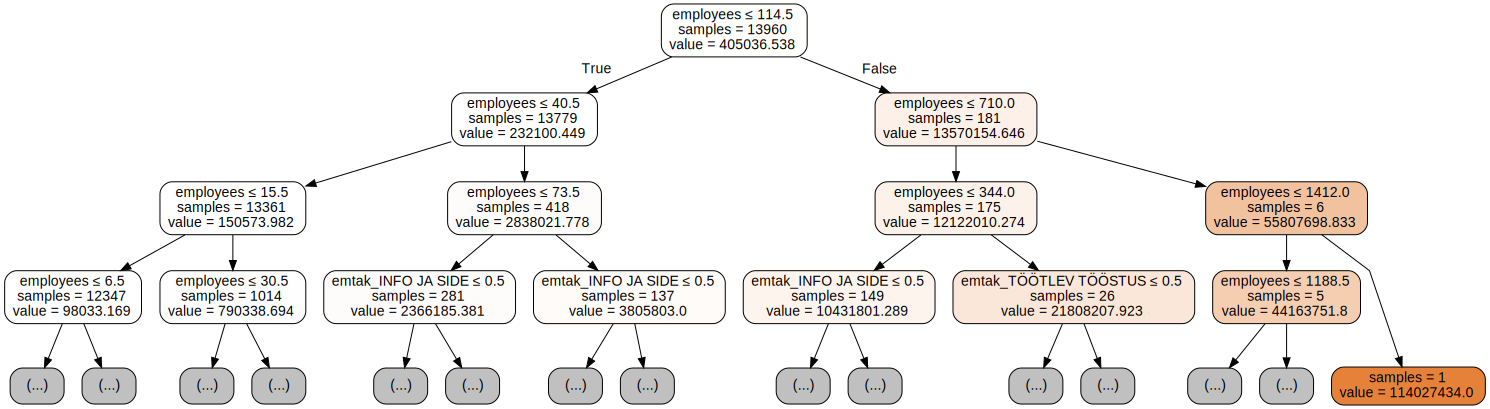

In [24]:
# Impordime tööriistad puu visualiseerimiseks
from sklearn import tree
import graphviz

# Loome puu
dot_data = tree.export_graphviz(model, 
                                feature_names=train_variables.columns,
                                max_depth=3,    
                                filled=True, 
                                rounded=True,
                                impurity=False,
                                leaves_parallel=True,  
                                special_characters=True)  
# Prindime puu välja
graph = graphviz.Source(dot_data)  
graph 

### Hindame muutujate olulisust

In [25]:
# Muutujate olulisust näeme:
model.feature_importances_

array([0.97866991, 0.        , 0.01468701, 0.00664308])

In [26]:
# Esitame muutujate olulisuse loetavamal kujul
pd.DataFrame({
    "Muutuja": test_variables.columns,
    "Olulisus": model.feature_importances_
    }).round(2)

Muutuja  Olulisus
0              employees      0.98
1           emtak_EHITUS      0.00
2     emtak_INFO JA SIDE      0.01
3  emtak_TÖÖTLEV TÖÖSTUS      0.01

# Anomaaliate tuvastamine
Kasutades `LocalOutlierFactor` mudelit, leiame read, mis tunduvad teistest oluliselt erinevat.

[Link allikale](https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html?highlight=anomaly%20detection)
 

In [27]:
numeric_data

employees    revenue  ...  emtak_INFO JA SIDE  emtak_TÖÖTLEV TÖÖSTUS
1            12.0   144389.0  ...                   1                      0
5             9.0    33043.0  ...                   0                      1
8           128.0  5924007.0  ...                   0                      1
9             6.0    25659.0  ...                   0                      1
10            8.0   141853.0  ...                   0                      0
...           ...        ...  ...                 ...                    ...
147076        3.0   143609.0  ...                   1                      0
147079        6.0    22225.0  ...                   1                      0
147121        2.0        0.0  ...                   1                      0
147220        3.0     4059.0  ...                   0                      1
147246        2.0    28218.0  ...                   1                      0

[17450 rows x 5 columns]

In [28]:
from sklearn.neighbors import LocalOutlierFactor

model = LocalOutlierFactor()
prediction = model.fit_predict(numeric_data)
prediction

array([1, 1, 1, ..., 1, 1, 1])

In [29]:
# Loome andmestiku, kuhu on lisatud märk anomaalsuse kohta
# -1 tähendab, et tegemist on anomaaliaga
# 1 tähendab, et tegemist on mitte-anomaaliaga
outlier_data = numeric_data.copy()
outlier_data['outlier'] = prediction

# Loeme anomaaliad ja normaalsed read kokku
outlier_data.value_counts(subset='outlier')

outlier
 1    17345
-1      105
dtype: int64